In [836]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import image

Определение необходимых функцияй

In [742]:
#Определение матриц поворота
#Вокруг оси х
def R_x(angl):
    Rx = np.array([[1,            0,             0],
                   [0, np.cos(angl), -np.sin(angl)],
                   [0, np.sin(angl),  np.cos(angl)]])
    return Rx

# вокруг оси у
def R_y(angl):
    Ry = np.array([[ np.cos(angl), 0, np.sin(angl)],
                   [ 0,            1,            0],
                   [-np.sin(angl), 0, np.cos(angl)]])
    return Ry

# вокруг оси z
def R_z(angl):
    Rz = np.array([[np.cos(angl), -np.sin(angl), 0],
                   [np.sin(angl),  np.cos(angl), 0],
                   [           0,             0, 1]])
    return Rz


In [743]:
#Определение произведения кватернионов
def quaternion_product(q, p):
    q_rez = np.array([q[0]*p[0]-q[1]*p[1]-q[2]*p[2]-q[3]*p[3],
                      q[0]*p[1]+q[1]*p[0]+q[2]*p[3]-q[3]*p[2],
                      q[0]*p[2]-q[1]*p[3]+q[2]*p[0]+q[3]*p[1],
                      q[0]*p[3]+q[1]*p[2]-q[2]*p[1]+q[3]*p[0]])
    return q_rez

In [744]:
# Функция перевода декартовых координат в углы
def dekart_to_angle(r, z):
    
    #координаты векторов в проекционных плоскостях
    #вектор в проекционных плоскостях
    r_zx = np.array([r[0], r[2]])
    r_zy = np.array([r[1], r[2]])
    
    #вектор орты z в проекционных плоскостях
    zx = np.array([z[0], z[2]])
    zy = np.array([z[1], z[2]])
    
    #проверка на ошибку
    if (all(r_zx == 0) or all(r_zy == 0)):
        raise ValueError("error - нулевой вектор")
    
    #нормы векторов проекций
    mod_r_zx = np.linalg.norm(r_zx,  ord=2)
    mod_r_zy = np.linalg.norm(r_zy,  ord=2)
    mod_zx = np.linalg.norm(zx,  ord=2)
    mod_zy = np.linalg.norm(zy,  ord=2)
    
    #результирующие углы в радианах
    phi_zx = np.arccos((r_zx[0]*zx[0]+r_zx[1]*zx[1])/(mod_r_zx*mod_zx))
    phi_zy = np.arccos((r_zy[0]*zy[0]+r_zy[1]*zy[1])/(mod_r_zy*mod_zy))
    
    angl = np.array([phi_zx, phi_zy])
    return angl

приблизительные формулы обратного перехода

\begin{equation}
 \begin{cases}
  z^2 + x^2 + y^2 = 1\\
  \frac{z}{\sqrt{x^2 + z^2}} = \cos{\phi_{zx}}\\
   \frac{z}{\sqrt{y^2 + z^2}} = \cos{\phi_{zy}}\\
 \end{cases}
\end{equation}

и график того как я понял задачу

<IPython.core.display.Javascript object>


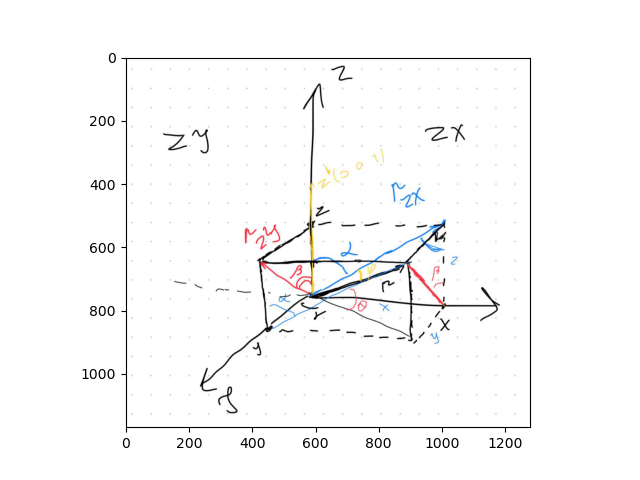

In [837]:
img = image.imread("D:\gr.jpg")
plt.imshow(img)
plt.show()

In [838]:
# Функция перевода углов в декартовы координаты
def angle_to_dekart(phi_zx, phi_zy): 
    
    z = 1/(np.sqrt(1+np.tan(phi_zy)**2+np.tan(phi_zx)**2))
    x = np.sqrt(1-(z**2)*(1+np.tan(phi_zx)**2))
    y = np.sqrt(1-(z**2)*(1+np.tan(phi_zy)**2))
    
    r = np.array([[x],
                  [y],
                  [z]])
    
    return r

Углы пворота различают на углы Эйлера и Тейта - Брайана, которые различаются последовательностью поворотов через углы Эйлера это по вороты в двух осях, а Тейта - Брайана через последовательные повороты вокруг всех осей тоже справедливо и для поворотов через кватернионы реализуемые через произведение поворотов в соответствующих осях их произведением.
реализуем по 6 поворотов Любое внешнее вращение эквивалентно внутреннему вращению на те же углы, но с обратным порядком элементарных вращений, и наоборот. Например, внутренние вращения x-y'-z″ на углы α , β , γ эквивалентны внешним вращениям zyx на углы γ , β , α ..
ref:
https://en.wikipedia.org/wiki/Davenport_chained_rotations
https://en.wikipedia.org/wiki/Euler_angles

вращения задаются следующими наборами поворотов вокруг соответствующих осей:

$Euler$ $angles:$ $(z-x-z, x-y-x, y-z-y, z-y-z, x-z-x, y-x-y)$

$Tait–Bryan$ $angles:$ $(x-y-z, y-z-x, z-x-y, x-z-y, z-y-x, y-x-z)$

In [749]:
# углы Эйлера
alpha = np.pi/4
beta = np.pi/4
gamma = np.pi/4
# углы Тейта - Брайана
psi = np.pi/4
tet = np.pi/4
phi = np.pi/4
# еденичный вектор x
x = np.array([[1],
              [0],
              [0]])
# еденичный вектор z
z = np.array([[0],
              [0],
              [1]])

In [750]:
R_z(alpha).dot(R_x(beta).dot(R_z(gamma).dot(z)))

array([[ 0.5       ],
       [-0.5       ],
       [ 0.70710678]])

In [751]:
# Функция расчета поворотов через матрицы поворотов и углы Эйлера
def Euler_rotations(initial_vector, alpha, beta, gamma,
                    type_of_rotation, sequence_of_rotation="default"):
    
    if (type_of_rotation == "extrinsic"):
                    
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")

        elif(sequence_of_rotation =="XZX"):
            return R_x(alpha).dot(R_z(beta).dot(R_x(gamma).dot(initial_vector)))

        elif(sequence_of_rotation =="XYX"):
            return R_x(alpha).dot(R_y(beta).dot(R_x(gamma).dot(initial_vector)))

        elif(sequence_of_rotation =="YXY"):
            return R_y(alpha).dot(R_x(beta).dot(R_y(gamma).dot(initial_vector)))

        elif(sequence_of_rotation =="YZY"):
            return R_y(alpha).dot(R_z(beta).dot(R_y(gamma).dot(initial_vector)))

        elif(sequence_of_rotation =="ZYZ"):
            return R_z(alpha).dot(R_y(beta).dot(R_z(gamma).dot(initial_vector)))

        elif(sequence_of_rotation =="ZXZ"):
            return R_z(alpha).dot(R_x(beta).dot(R_z(gamma).dot(initial_vector)))

        else:
            raise ValueError("error - неправильно задана последовательность поворотов")
            
    elif (type_of_rotation == "intrinsic"):
        
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")
            
        elif(sequence_of_rotation =="XZX"):
            return R_x(gamma).dot(R_z(beta).dot(R_x(alpha).dot(initial_vector)))

        elif(sequence_of_rotation =="XYX"):
            return R_x(gamma).dot(R_y(beta).dot(R_x(alpha).dot(initial_vector)))

        elif(sequence_of_rotation =="YXY"):
            return R_y(gamma).dot(R_x(beta).dot(R_y(alpha).dot(initial_vector)))

        elif(sequence_of_rotation =="YZY"):
            return R_y(gamma).dot(R_z(beta).dot(R_y(alpha).dot(initial_vector)))

        elif(sequence_of_rotation =="ZYZ"):
            return R_z(gamma).dot(R_y(beta).dot(R_z(alpha).dot(initial_vector)))

        elif(sequence_of_rotation =="ZXZ"):
            return R_z(gamma).dot(R_x(beta).dot(R_z(alpha).dot(initial_vector)))

        else:
            raise ValueError("error - неправильно задана последовательность поворотов")
            
    else:
        raise ValueError("error - тип поворота не задан")

Повороты это ортогональное преобразование, а значит $A^{-1} = A^{T}$ операторы поворотов

In [752]:
# Функция расчета обратного поворотов через матрицы поворотов и углы Эйлера
def Euler_rotations_invers(initial_vector, alpha, beta, gamma,
                    type_of_rotation, sequence_of_rotation="default"):
    
    if (type_of_rotation == "extrinsic"):
                    
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")

        elif(sequence_of_rotation =="XZX"):
            return ((((R_x(alpha).dot(R_z(beta).dot(R_x(gamma)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="XYX"):
            return ((((R_x(alpha).dot(R_y(beta).dot(R_x(gamma)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="YXY"):
            return ((((R_y(alpha).dot(R_x(beta).dot(R_y(gamma)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="YZY"):
            return ((((R_y(alpha).dot(R_z(beta).dot(R_y(gamma)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="ZYZ"):
            return ((((R_z(alpha).dot(R_y(beta).dot(R_z(gamma)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="ZXZ"):
            return (R_z(gamma).T).dot((R_x(beta).T).dot((R_z(alpha).T).dot(initial_vector)))
        else:
            raise ValueError("error - неправильно задана последовательность поворотов")
            
    elif (type_of_rotation == "intrinsic"):
        
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")
            
        elif(sequence_of_rotation =="XZX"):
            return ((((R_x(gamma).dot(R_z(beta).dot(R_x(alpha)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="XYX"):
            return ((((R_x(gamma).dot(R_y(beta).dot(R_x(alpha)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="YXY"):
            return ((((R_y(gamma).dot(R_x(beta).dot(R_y(alpha)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="YZY"):
            return ((((R_y(gamma).dot(R_z(beta).dot(R_y(alpha)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="ZYZ"):
            return ((((R_z(gamma).dot(R_y(beta).dot(R_z(alpha)))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="ZXZ"):
            return ((((R_z(gamma).dot(R_x(beta).dot(R_z(alpha)))).T).dot(initial_vector)))

        else:
            raise ValueError("error - неправильно задана последовательность поворотов")
            
    else:
        raise ValueError("error - тип поворота не задан")

проверка прямого и обратного преобразования

In [753]:
c = Euler_rotations(x, alpha, beta, gamma, type_of_rotation = "extrinsic", sequence_of_rotation="XYX")
c

array([[ 0.70710678],
       [ 0.5       ],
       [-0.5       ]])

In [754]:
Euler_rotations_invers(c, alpha, beta, gamma, type_of_rotation = "extrinsic", sequence_of_rotation="XYX")

array([[ 1.00000000e+00],
       [-1.11022302e-16],
       [-1.11022302e-16]])

In [755]:
# Функция расчета поворотов через матрицы поворотов и углы Тейта - Брайана
def Tait_Bryan(initial_vector, phi, tet, psi,
               type_of_rotation, sequence_of_rotation="default"):
    
    if (type_of_rotation == "extrinsic"):
                    
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")

        elif(sequence_of_rotation =="XYZ"):
            return R_x(phi).dot(R_y(tet).dot(R_z(psi).dot(initial_vector)))

        elif(sequence_of_rotation =="YZX"):
            return R_y(phi).dot(R_z(tet).dot(R_x(psi).dot(initial_vector)))

        elif(sequence_of_rotation =="ZXY"):
            return R_z(phi).dot(R_x(tet).dot(R_y(psi).dot(initial_vector)))

        elif(sequence_of_rotation =="XZY"):
            return R_x(phi).dot(R_z(tet).dot(R_y(psi).dot(initial_vector)))

        elif(sequence_of_rotation =="ZYX"):
            return R_z(phi).dot(R_y(tet).dot(R_x(psi).dot(initial_vector)))

        elif(sequence_of_rotation =="YXZ"):
            return R_y(phi).dot(R_x(tet).dot(R_z(psi).dot(initial_vector)))

        else:
            raise ValueError("error - неправильно задана последовательность поворотов")
            
    elif (type_of_rotation == "intrinsic"):
        
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")
            
        elif(sequence_of_rotation =="XYZ"):
            return R_z(psi).dot(R_y(tet).dot(R_x(phi).dot(initial_vector)))

        elif(sequence_of_rotation =="YZX"):
            return R_x(psi).dot(R_z(tet).dot(R_y(phi).dot(initial_vector)))

        elif(sequence_of_rotation =="ZXY"):
            return R_y(psi).dot(R_x(tet).dot(R_z(phi).dot(initial_vector)))

        elif(sequence_of_rotation =="XZY"):
            return R_y(psi).dot(R_z(tet).dot(R_x(phi).dot(initial_vector)))

        elif(sequence_of_rotation =="ZYX"):
            return R_x(psi).dot(R_y(tet).dot(R_z(phi).dot(initial_vector)))

        elif(sequence_of_rotation =="YXZ"):
            return R_z(psi).dot(R_x(tet).dot(R_y(phi).dot(initial_vector)))

        else:
            raise ValueError("error - неправильно задана последовательность поворотов")
            
    else:
        raise ValueError("error - тип поворота не задан")

In [756]:
# Функция расчета поворотов через матрицы поворотов и углы Тейта - Брайана
def Tait_Bryan_invers(initial_vector, phi, tet, psi,
               type_of_rotation, sequence_of_rotation="default"):
    
    if (type_of_rotation == "extrinsic"):
                    
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")

        elif(sequence_of_rotation =="XYZ"):
            return ((((((R_x(phi).dot(R_y(tet).dot(R_z(psi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="YZX"):
            return ((((((R_y(phi).dot(R_z(tet).dot(R_x(psi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="ZXY"):
            return ((((((R_z(phi).dot(R_x(tet).dot(R_y(psi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="XZY"):
            return ((((((R_x(phi).dot(R_z(tet).dot(R_y(psi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="ZYX"):
            return ((((((R_z(phi).dot(R_y(tet).dot(R_x(psi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="YXZ"):
            return ((((((R_y(phi).dot(R_x(tet).dot(R_z(psi)))))).T).dot(initial_vector)))

        else:
            raise ValueError("error - неправильно задана последовательность поворотов")
            
    elif (type_of_rotation == "intrinsic"):
        
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")
            
        elif(sequence_of_rotation =="XYZ"):
            return ((((((R_z(psi).dot(R_y(tet).dot(R_x(phi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="YZX"):
            return ((((((R_x(psi).dot(R_z(tet).dot(R_y(phi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="ZXY"):
            return ((((((R_y(psi).dot(R_x(tet).dot(R_z(phi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="XZY"):
            return ((((((R_y(psi).dot(R_z(tet).dot(R_x(phi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="ZYX"):
            return ((((((R_x(psi).dot(R_y(tet).dot(R_z(phi)))))).T).dot(initial_vector)))

        elif(sequence_of_rotation =="YXZ"):
            return ((((((R_z(psi).dot(R_x(tet).dot(R_y(phi)))))).T).dot(initial_vector)))

        else:
            raise ValueError("error - неправильно задана последовательность поворотов")
            
    else:
        raise ValueError("error - тип поворота не задан")

проверка функций прямого и обратного преобразования

In [757]:
Tait_Bryan(x, 0, np.pi, np.pi/4, type_of_rotation = "extrinsic", sequence_of_rotation="XYZ")

array([[-7.07106781e-01],
       [ 7.07106781e-01],
       [-8.65956056e-17]])

In [758]:
Tait_Bryan_invers(Tait_Bryan(x, 0, np.pi, np.pi/4, type_of_rotation = "extrinsic", sequence_of_rotation="XYZ"),
                  0, np.pi, np.pi/4, type_of_rotation = "extrinsic", sequence_of_rotation="XYZ")

array([[ 1.00000000e+00],
       [-7.49879891e-33],
       [ 0.00000000e+00]])

In [759]:
x

array([[1],
       [0],
       [0]])

для кватернионов порядок поворота определяется порядком произведения 

In [760]:
# Определение матрицы поворота в 3х мерном пространстве через кватернионы
# и самолетные углы(углы Тейта - Брайана) xyz
def Q_R_Airplane_angles(alpha, beta, gamma):
    
    # кватернионы поворота по каждой из осей, нормированный на 1 
    q1 = np.array([np.cos(alpha/2), np.sin(alpha/2), 0, 0])
    q2 = np.array([np.cos(beta/2), 0, np.sin(beta/2), 0])
    q3 = np.array([np.cos(gamma/2), 0, 0, np.sin(gamma/2)])
    
    # произведение кватернионов как результирующий поворот
    q = quaternion_product(quaternion_product(q1, q2), q3)
    
    # матрица направляющих косинусов через коэфициенты кватерниона
    QR =  np.array([[q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2, 2*(q[1]*q[2] - q[0]*q[3]), 2*(q[0]*q[2] + q[1]*q[3])],
                    [2*(q[0]*q[3] + q[1]*q[2]), q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2, 2*(q[2]*q[3] - q[0]*q[1])],
                    [2*(q[1]*q[3] - q[0]*q[2]), 2*(q[0]*q[1] + q[2]*q[3]), q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2]])
    return QR

# Определение матрицы поворота в 3хмерном пространстве через кватернионы
# и углы Эйлера zxz
def Q_R_Euler_angles(psi, teta, phi):
    
    # кватернионы поворота по каждой из осей, нормированный на 1 
    q1 = np.array([np.cos(psi/2), 0, 0, np.sin(psi/2)])
    q2 = np.array([np.cos(teta/2), np.sin(teta/2), 0, 0])
    q3 = np.array([np.cos(phi/2), 0, 0, np.sin(phi/2)])
    
    # произведение кватернионов как результирующий поворот
    q = quaternion_product(quaternion_product(q1, q2), q3)
    
    # матрица направляющих косинусов через коэфициенты кватерниона
    QR =  np.array([[q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2, 2*(q[1]*q[2] - q[0]*q[3]), 2*(q[0]*q[2] + q[1]*q[3])],
                    [2*(q[0]*q[3] + q[1]*q[2]), q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2, 2*(q[2]*q[3] - q[0]*q[1])],
                    [2*(q[1]*q[3] - q[0]*q[2]), 2*(q[0]*q[1] + q[2]*q[3]), q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2]])
    return QR

In [848]:
#extrinsic 
#колличество итераций
N = 1000 
#время
t = np.linspace(0, 30, N)
#частота
w = 0.25
#амплитуда
A = 1/8
#углы параметризированные временем (качка)
phi_arr = A/2*np.sin(2*np.pi*w/5*t)
tet_arr = A*np.cos(2*np.pi*w/2.5*t)
psi_arr = A*np.sin(2*np.pi*w*t)

<IPython.core.display.Javascript object>


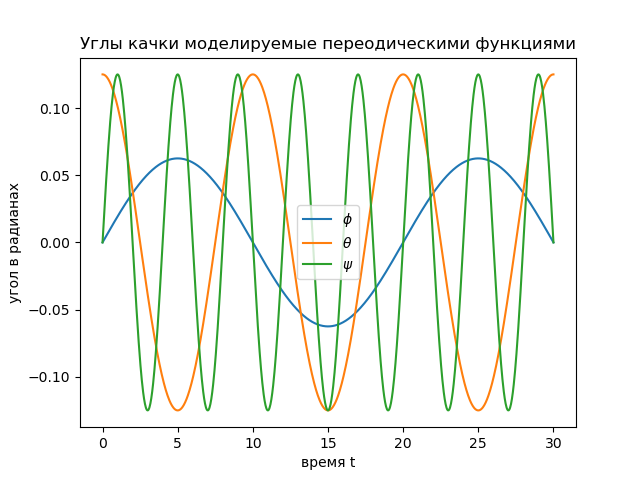

In [786]:
plt.plot(t, phi_arr, label=r'$\phi$')
plt.plot(t, tet_arr, label=r'$\theta$')
plt.plot(t, psi_arr, label=r'$\psi$')
plt.legend()
plt.xlabel('время t')
plt.ylabel('угол в радианах')
plt.title('Углы качки моделируемые переодическими функциями')
plt.show()

In [787]:
#моделирование через углы Тейта - Брайана и extrinsic rotation, 
# в виду интуитивно понятного вращения вокруг неподвижных осей
# входной вектор
r = np.array([[0],
              [0],
              [1]])
# определение результирующего вектора и углов
rez_vect = np.zeros((3, N))
phi_zx = np.zeros((N))
phi_zy = np.zeros((N))
rez_vect[:, 0] = r[:, 0]
# расчет всех поворотов как действия оператора во времени
for i in range(1, N-1):
    rez_vect[:, i] = Tait_Bryan(r, phi_arr[i], tet_arr[i], psi_arr[i], type_of_rotation = "extrinsic", sequence_of_rotation="XYZ")[:,0]

In [839]:
#расчет углов в проекциях zx и zy
for i in range(0, N-1):   
    phi_zx[i] = math.degrees(dekart_to_angle(rez_vect[:,i], z)[0])
    phi_zy[i] = math.degrees(dekart_to_angle(rez_vect[:,i], z)[1])

C:\Users\Йося\AppData\Local\Temp\ipykernel_9048\1972938748.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_zx[i] = math.degrees(dekart_to_angle(rez_vect[:,i], z)[0])
C:\Users\Йося\AppData\Local\Temp\ipykernel_9048\1972938748.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_zy[i] = math.degrees(dekart_to_angle(rez_vect[:,i], z)[1])


<IPython.core.display.Javascript object>


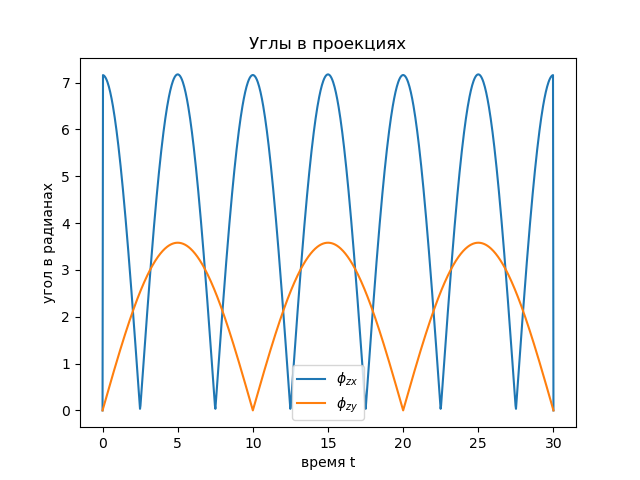

In [840]:
# графики углов в проекциях на zx и zy
plt.plot(t, phi_zx, label=r'$\phi_{zx}$')
plt.plot(t, phi_zy, label=r'$\phi_{zy}$')
plt.legend()
plt.xlabel('время t')
plt.ylabel('угол в радианах')
plt.title('Углы в проекциях')
plt.show()

проверка обратного 

In [841]:
r_chec = np.zeros((3,N))
for i in range(0,N-1):
    r_chec[:, i] = angle_to_dekart(phi_zy[i], phi_zx[i] )[:,0]


C:\Users\Йося\AppData\Local\Temp\ipykernel_9048\3219710436.py:6: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt(1-(z**2)*(1+np.tan(phi_zy)**2))


In [842]:
angle_to_dekart(np.pi/2,np.pi/2 )

array([[7.07106781e-01],
       [7.07106781e-01],
       [4.32978028e-17]])

<IPython.core.display.Javascript object>


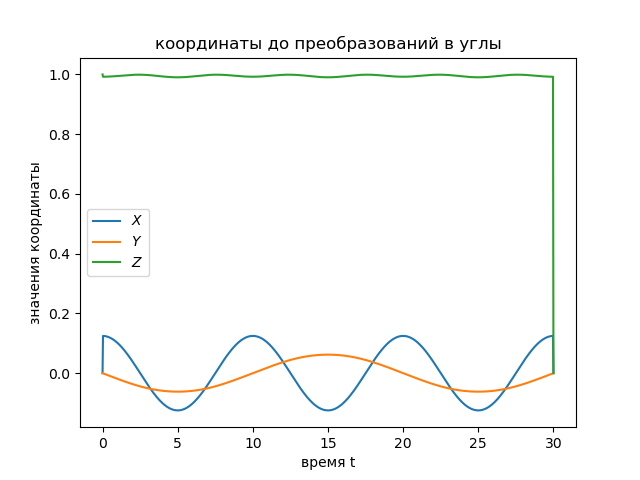

In [843]:
# координаты до преобразования в углы
plt.plot(t, rez_vect[0,:], label=r'$X$')
plt.plot(t, rez_vect[1,:], label=r'$Y$')
plt.plot(t, rez_vect[2,:], label=r'$Z$')
plt.legend()
plt.xlabel('время t')
plt.ylabel('значения координаты')
plt.title('координаты до преобразований в углы')
plt.show()

<IPython.core.display.Javascript object>


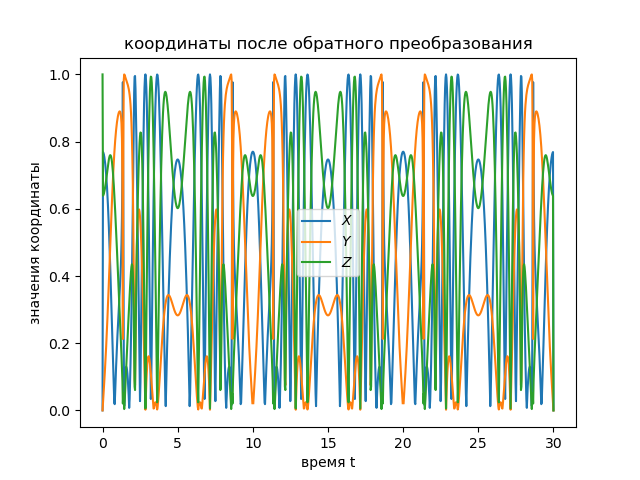

In [844]:
# проверка обратного преобразования из углов в координаты
plt.plot(t, r_chec[0,:], label=r'$X$')
plt.plot(t, r_chec[1,:], label=r'$Y$')
plt.plot(t, r_chec[2,:], label=r'$Z$')
plt.legend()
plt.xlabel('время t')
plt.ylabel('значения координаты')
plt.title('координаты после обратного преобразования')
plt.show()

In [845]:
norma_rez = np.zeros((N-1))
for i in range(0,N-1):
    norma_rez[i] = np.linalg.norm(rez_vect[:,i],  ord=2)

после преобразований норма сохранилась что и ожидалось

<IPython.core.display.Javascript object>


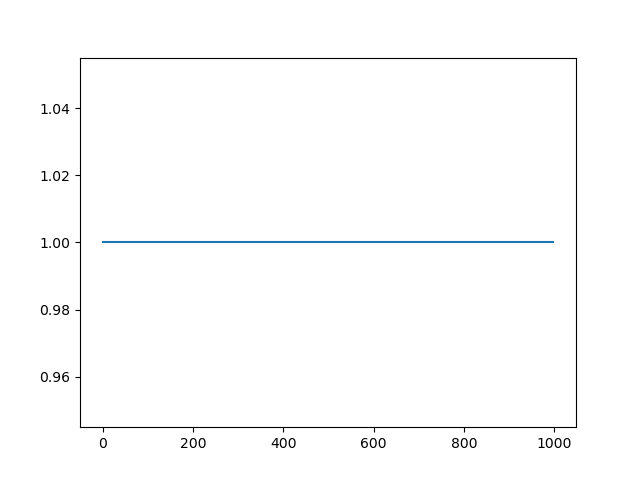

In [846]:
plt.plot(norma_rez)

Анимация движения вектора под качкой параметризованными углами

<IPython.core.display.Javascript object>


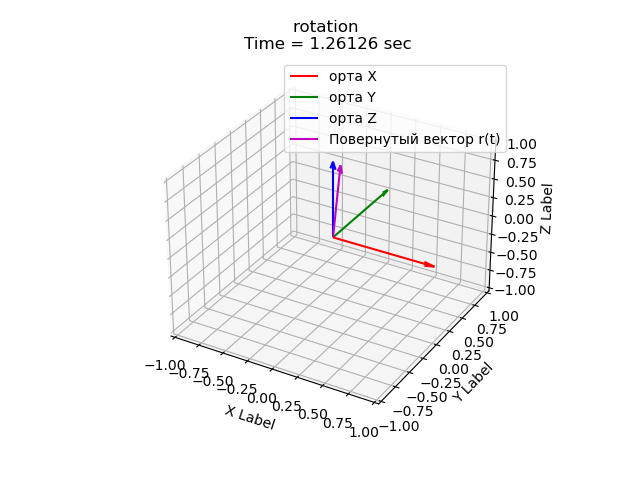

In [847]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.clear()
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, label=r'орта X')
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, label=r'орта Y')
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', arrow_length_ratio=0.1, label=r'орта Z')
    ax.quiver(0, 0, 0, rez_vect[0, frame], rez_vect[1, frame], rez_vect[2, frame], color='m', arrow_length_ratio=0.1, label=r'Повернутый вектор r(t)')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    
    ax.set_title('rotation \nTime = ' + str((float('{:.5f}'.format(frame*(t[1]-t[0]))))) + ' sec')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.legend()
ani = FuncAnimation(fig, update, frames=N, interval=5)
plt.show()